In [1]:
import os
import glob
import pandas as pd
from Bio import SeqIO
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import numpy as np

In [4]:
# Generate files for each protein containing the IDs of sequences that did not align,
# as well as the total number of initial sequences,
# the number of sequences that did not align,
# and the number of sequences that did align.

# Directory containing the FASTA and outfmt6 files
directory = "./"

# Register all FASTA files
fasta_files = glob.glob(os.path.join(directory, "*.fasta"))

for fasta_file in fasta_files:
    base_name = os.path.splitext(os.path.basename(fasta_file))[0]
    outfmt6_file = fasta_file.replace(".fasta", ".outfmt6")

    if not os.path.exists(outfmt6_file):
        print(f"⚠️ {outfmt6_file} not found, skipping...")
        continue

    # --- 1. Extract FASTA IDs ---
    seq_records = list(SeqIO.parse(fasta_file, "fasta"))
    fasta_ids = [rec.id for rec in seq_records]

    total_sequences = len(fasta_ids)

    # --- 2. Reads outfmt6 first column (if not empty) ---
    if os.path.getsize(outfmt6_file) > 0:
        df_out = pd.read_csv(outfmt6_file, sep="\t", header=None)
        aligned_ids = set(df_out[0].astype(str).tolist())
    else:
        print(f"ℹ️ {outfmt6_file} empty → no sequence aligned")
        aligned_ids = set()

    aligned_count = len(aligned_ids)
    not_aligned_count = total_sequences - aligned_count

    # --- 3. Indentify non aligned IDs ---
    not_aligned_ids = [seq_id for seq_id in fasta_ids if seq_id not in aligned_ids]

    # --- 4. Create DataFrame ---
    df_na = pd.DataFrame({"not_aligned_ids": not_aligned_ids})

    # Add a final summary line
    summary = pd.DataFrame({
        "not_aligned_ids": ["--SUMMARY--"],
        "total_sequences": [total_sequences],
        "aligned": [aligned_count],
        "not_aligned": [not_aligned_count]
    })
    df_na = pd.concat([df_na, summary], ignore_index=True)

    # --- 5. Save in CSV ---
    output_file = os.path.join(
        directory, base_name.replace("_merged_nr", "") + "_NA.csv"
    )
    df_na.to_csv(output_file, index=False)

    print(f"✅ {len(not_aligned_ids)} not aligned (out of {total_sequences}) saved to {output_file}")

✅ 248 not aligned (out of 16531) saved to ./kpsT_NA.csv
✅ 17412 not aligned (out of 119433) saved to ./nanA_NA.csv
✅ 8094 not aligned (out of 17576) saved to ./nanR_NA.csv
✅ 161 not aligned (out of 39302) saved to ./nanE_NA.csv
✅ 114 not aligned (out of 147) saved to ./cpsK_NA.csv
✅ 26751 not aligned (out of 80083) saved to ./neuA_NA.csv
✅ 2310 not aligned (out of 4070) saved to ./nanC_NA.csv
✅ 780 not aligned (out of 13542) saved to ./nanT_NA.csv
✅ 282105 not aligned (out of 602980) saved to ./siaQ_NA.csv
✅ 1032 not aligned (out of 6920) saved to ./nanM_NA.csv
✅ 0 not aligned (out of 4739) saved to ./satA_nr_NA.csv
✅ 4750 not aligned (out of 6803) saved to ./lst_NA.csv
✅ 2096 not aligned (out of 32451) saved to ./nanK_NA.csv
✅ 567 not aligned (out of 14461) saved to ./kpsD_NA.csv
✅ 94972 not aligned (out of 199890) saved to ./neuC_NA.csv
✅ 1474 not aligned (out of 12595) saved to ./nanQ_NA.csv
✅ 374582 not aligned (out of 545207) saved to ./nagB_NA.csv
✅ 7 not aligned (out of 32) save

In [5]:
# Move all count files to a dedicate directory

! mkdir NA
! mv *NA.csv NA

In [6]:
# Consolidates all count files into a single file

directory = "./NA"   

# List to record the results
results = []

# Iterate through all the CSV files in the directory
for file in os.listdir(directory):
    if file.endswith(".csv"):
        path = os.path.join(directory, file)

        # take the part before the first “_” in the file name
        gene = file.split("_")[0]

        with open(path, "r") as f:
            lines = f.readlines()
            # last line contains the summary
            for line in lines:
                if line.startswith("--SUMMARY--"):
                    parts = line.strip().split(",")
                    total_sequences = float(parts[1])
                    aligned = float(parts[2])
                    not_aligned = float(parts[3])
                                        
                    results.append({
                        "gene": gene,
                        "total_sequences": int(total_sequences),
                        "aligned": int(aligned),
                        "not_aligned": int(not_aligned)
                    })

# Creates a dataframe with all results
df = pd.DataFrame(results)

# Saves consolidated file in CSV format
output = "summary.csv"
df.to_csv(output, index=False)

print(f"Final consolidated file saved in: {output}")
print(df)

Final consolidated file saved in: summary.csv
     gene  total_sequences  aligned  not_aligned
0   lic3B                6        3            3
1    ompC            48286    18996        29290
2    nagA           204310   200329         3981
3    kpsE            11086     9399         1687
4    neuC           199890   104918        94972
5    neuD            16540     3932        12608
6     lst             6803     2053         4750
7    siaT            75885    74864         1021
8    nanA           119433   102021        17412
9    satD             4887     4887            0
10   siaQ           602980   320875       282105
11   nanM             6920     5888         1032
12   SIAE           131128   108999        22129
13   kpsD            14461    13894          567
14   nagB           545207   170625       374582
15   ompF            72682    10992        61690
16   satB             4710     4710            0
17   neuO              262      134          128
18   nanK            32

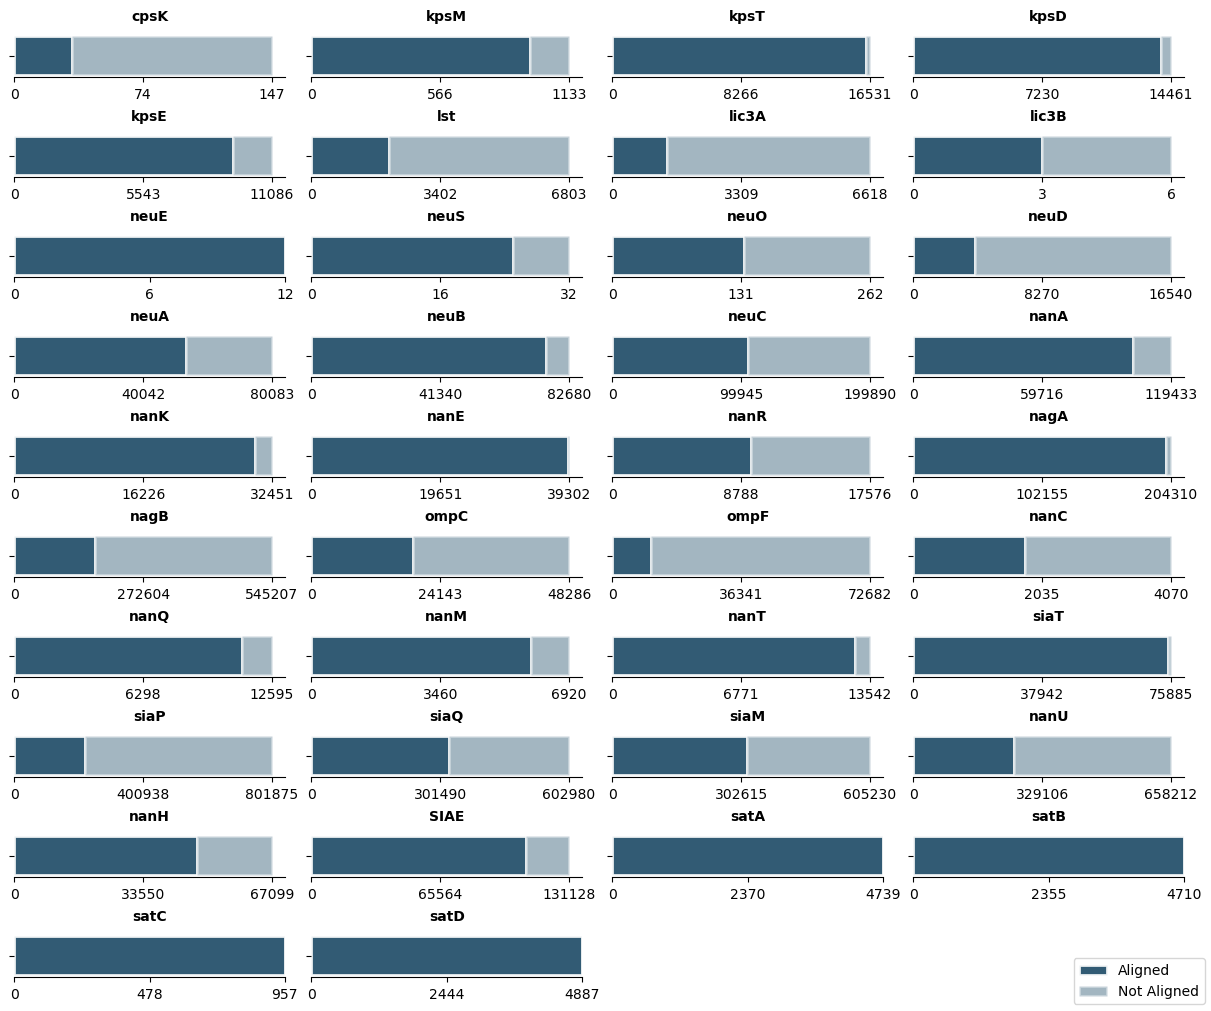

In [10]:
# Read input data
df = pd.read_csv("./summary.csv")

# Define the desired gene order
gene_order = [
    "cpsK", "kpsM", "kpsT", "kpsD",
    "kpsE", "lst", "lic3A", "lic3B",
    "neuE", "neuS", "neuO", "neuD",
    "neuA", "neuB", "neuC", "nanA",
    "nanK", "nanE", "nanR", "nagA",
    "nagB", "ompC", "ompF", "nanC",
    "nanQ", "nanM", "nanT", "siaT",
    "siaP", "siaQ", "siaM", "nanU",
    "nanH", "SIAE", "satA", "satB",
    "satC", "satD"
]

# Reorder DataFrame according to the specified gene order
df["gene"] = pd.Categorical(
    df["gene"],
    categories=gene_order,
    ordered=True
)

df = df.sort_values("gene").reset_index(drop=True)

# Number of plots
n = len(df)
ncols = 4
nrows = math.ceil(n / ncols)

# Create figure and axes grid
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols * 3, nrows * 1),
    constrained_layout=True
)

axes = axes.flatten()

# Define color
color = "#1b4965"

# Plot data
for i, row in df.iterrows():
    gene = row["gene"]
    total = row["total_sequences"]
    aligned = row["aligned"]
    not_aligned = row["not_aligned"]

    # Stacked horizontal bar plot
    axes[i].barh(
        0,
        aligned,
        height=0.15,
        color=color,
        alpha=0.9,
        edgecolor="white",
        linewidth=2,
        label="Aligned"
    )

    axes[i].barh(
        0,
        not_aligned,
        left=aligned,
        height=0.15,
        color=color,
        alpha=0.4,
        edgecolor="white",
        linewidth=2,
        label="Not Aligned"
    )

    # Axis formatting
    axes[i].set_yticks([0])
    axes[i].set_yticklabels([""])
    axes[i].set_title(gene, fontsize=10, fontweight="bold", pad=10)

    midpoint = total / 2
    axes[i].set_xticks([0, midpoint, total])
    axes[i].set_xticklabels([0, f"{midpoint:.0f}", f"{total:.0f}"])

    axes[i].spines[["top", "right", "left"]].set_visible(False)
    axes[i].tick_params(axis="x")

# Remove unused axes (if the grid is larger than the number of genes)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right")

plt.show()